In [1]:
# Imports & Setup

from libs import *

base_players_dataset = pd.read_csv(PROJECT_FOLDER + 'files/base_players_dataset.csv')

<AxesSubplot:>

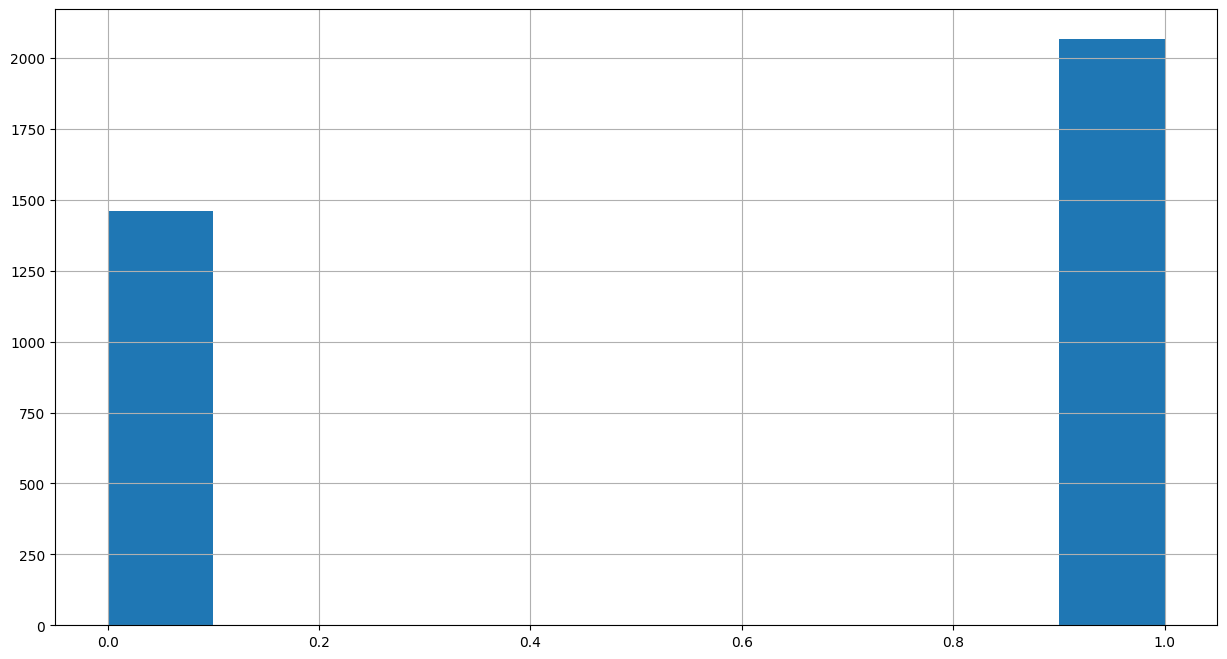

In [2]:
# Prepare df for stratify

value_bins = [-np.inf, 0, np.inf]

base_players_dataset['value_cat'] = pd.cut(base_players_dataset["value_diff"], bins=value_bins, labels=range(len(value_bins)-1))

base_players_dataset['value_cat'].hist()

In [3]:
# Create test set

from sklearn.model_selection import train_test_split

players_for_analysis = base_players_dataset[:]

players_for_analysis.dropna(subset=['value_cat'], inplace=True)

x_train, x_test, y_train, y_test = train_test_split(players_for_analysis, players_for_analysis['value_cat'], test_size=0.2, random_state=42, stratify=players_for_analysis['value_cat'])

In [4]:
# Revert to clean training set

players_v1 = x_train.drop('value_cat', axis=1)
players_labels_v1 = x_train['value_cat'].copy()

In [94]:
# Custom Nation transformer

from sklearn.base import BaseEstimator, TransformerMixin

class NationToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        nation_encoder = base_players_dataset.groupby('Nation').sum().rank(ascending=True, method='first')
        max_rank = nation_encoder['value_diff'].max()
        temp = nation_encoder.copy()
        temp.sort_values('value_diff', ascending=False, inplace=True)
        temp['Nation'] = temp.index
        temp.reset_index(drop=True, inplace=True)
        temp['Nation_rank'] = 1 - (temp.index / temp.shape[0])
        X['Nation_rank'] = X['Nation'].map(temp.set_index('Nation')['Nation_rank'])
        X.drop('Nation', axis=1, inplace=True)
        
        # fifa_wr = pd.read_csv(PROJECT_FOLDER + "datasets/fifa_ranking-2021-05-27.csv")
        # nation_encoder = fifa_wr.query('rank_date == "2020-10-22"')[['rank', 'country_abrv']]
        # max_rank = nation_encoder['rank'].max() + 1
        # X['Nation_rank'] = 1 - (X['Nation'].map(nation_encoder.set_index('country_abrv')['rank']).fillna(max_rank) / max_rank)
        # X.drop('Nation', axis=1, inplace=True)
        return X

In [135]:
# Custom Attributes transformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from utils import apply_mean_attribute_list, PLAYER_ATTR

class AttributeMerger(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        physical_attr = ['Acc', 'Pac', 'Sta', 'Str', 'Agi', 'Bal', 'Jum', 'Nat']
        mental_attr = ['Wor', 'Vis', 'Tea', 'Pos', 'OtB', 'Ldr', 'Fla', 'Det', 'Dec', 'Cnt', 'Cmp', 'Bra', 'Ant', 'Agg']
        apply_mean_attribute_list(X, 'M+P', physical_attr + mental_attr)
        X['M+P'] = X['M+P'] / 20
        X.drop(PLAYER_ATTR, axis=1, inplace=True)
        return X


In [136]:
# Custom Based transformer

from sklearn.base import BaseEstimator, TransformerMixin

class BasedToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        based_encoder = pd.read_csv(PROJECT_FOLDER + 'files/based_rank.csv')
        X['Based_rank'] = X['Based'].map(based_encoder.set_index('Based')['Based_rank'])
        X.drop('Based', axis=1, inplace=True)
        return X

In [137]:
# Custom Foot transformer

from sklearn.base import BaseEstimator, TransformerMixin

class FootToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Foot_rank'] = X['Preferred Foot'].map(FOOTEDNESS_MAPPING)
        X.drop('Preferred Foot', axis=1, inplace=True)
        return X

In [138]:
# Using transformation pipelines

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from utils import PLAYER_ATTR

players = x_train.drop('Value', axis=1)

features_v1 = {
    'att': (PLAYER_ATTR, ['M+P']),
    'num': (PLAYER_ATTR + ['Age'], None),
    # 'foo': (['Preferred Foot'], None),
    'pos': (['Best Pos'], None),
    #'nat': (['Nation'], None),
    'bas': (['Based'], None)
}

feature_labels_v1 = list(np.concatenate([f[1] if f[1] is not None else f[0] for k, f in features_v1.items()]).flat)

full_pipeline_v1 = ColumnTransformer([
    ("att", AttributeMerger(), features_v1['att'][0]),
    ("num", StandardScaler(), features_v1['num'][0]),
    # ("foo", FootToRank(), features_v1['foo'][0]),
    ("pos", OneHotEncoder(), features_v1['pos'][0]),
    #("nat", NationToRank(), features_v1['nat'][0]),
    ("bas", BasedToRank(), features_v1['bas'][0])
])

players_prepared_v1 = full_pipeline_v1.fit_transform(players)

In [139]:
# Hyperparameter tuning

import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

tune_hyperparameters = False

if not tune_hyperparameters:
    value_predictor_v1 = joblib.load(PROJECT_FOLDER + 'models/rf_value_predictor.pkl')
else:
    total_value_without_model = x_train['value_diff'].sum()

    def predictor_performance(estimator, X, y):
        y_pred = estimator.predict(X)
        values = x_train[['value_diff']]
        values['y_true'] = y
        values.dropna(inplace=True)
        values['pred'] = y_pred

        total_value_without_model = values['value_diff'].sum()
        total_value_with_model = values.query('pred == 1')['value_diff'].sum()

        score = total_value_with_model / total_value_without_model
        return score

    rf_param_grid = {
        'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 20)],
        'max_depth': [int(x) for x in np.linspace(10, 100, num = 5)] + [None],
        'bootstrap': [True, False],
    }

    value_predictor_v1 = RandomForestClassifier()
    value_predictor_v1_grid_search = RandomizedSearchCV(value_predictor_v1, rf_param_grid, cv=10, scoring='accuracy', return_train_score=True, n_iter=10, error_score="raise")

    value_predictor_v1_grid_search.fit(players_prepared_v1, players_labels_v1)

    value_predictor_v1 = value_predictor_v1_grid_search.best_estimator_

    joblib.dump(value_predictor_v1, 'models/rf_value_predictor.pkl')


In [140]:
# Select and train model
## RandomForestClassifier

value_predictor_v1.fit(players_prepared_v1, players_labels_v1)

RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=415)

In [141]:
import joblib

joblib.dump(value_predictor_v1, 'models/rf_value_predictor.pkl')

['models/rf_value_predictor.pkl']

In [142]:
# Test best threshold

value_predictions_proba_v1 = value_predictor_v1.predict_proba(players_prepared_v1)

total_value_without_model = x_train['value_diff'].sum()
max_value_without_model = x_train.query('value_diff > 0')['value_diff'].sum()
max_performance = (max_value_without_model - total_value_without_model) / total_value_without_model

train_players = x_train[:]
train_players['prob_1'] = value_predictions_proba_v1[:, 1]

model_performance_max = 0
ideal_threshold = 0
total_value_with_model_max = 0

for i in range(100):
    threshold = i / 100
    train_players['pred'] = value_predictions_proba_v1[:, 1] > threshold
    total_value_with_model = train_players.query('pred == 1')['value_diff'].sum()
    model_performance = (total_value_with_model - total_value_without_model) / total_value_without_model
    if model_performance > model_performance_max:
        model_performance_max = model_performance
        ideal_threshold = threshold
        total_value_with_model_max = total_value_with_model

print("Perf:", model_performance_max)
print("Max Perf:", max_performance)
print("Thres:", ideal_threshold)


Perf: 2.3180045541184047
Max Perf: 2.35818234107604
Thres: 0.49


<AxesSubplot:>

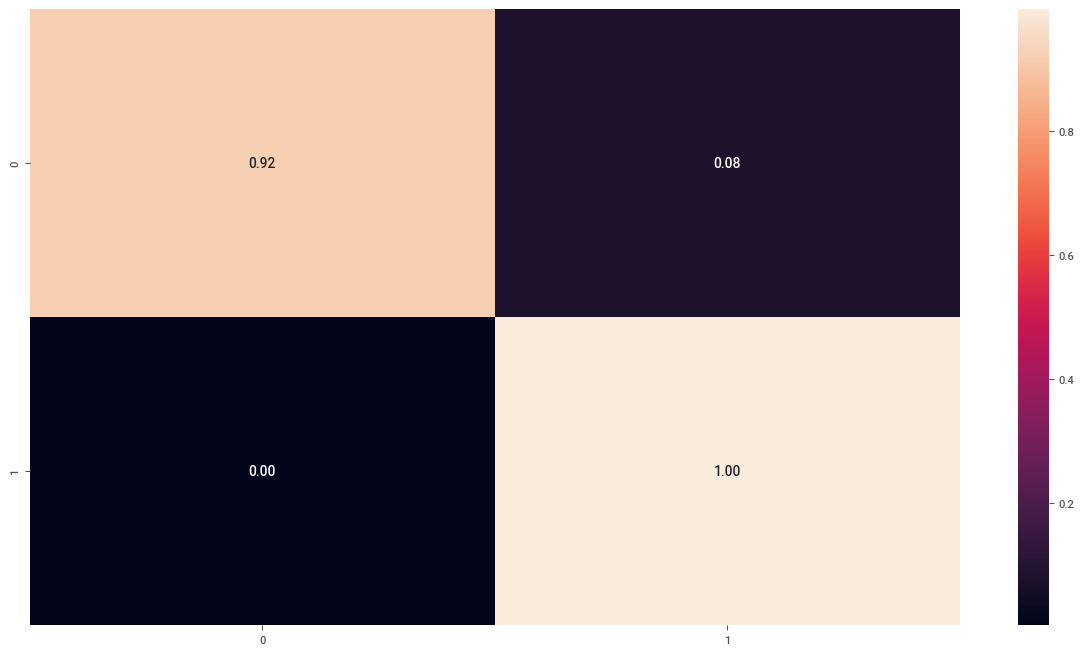

In [143]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(players_labels_v1, value_predictions_proba_v1[:, 1] > ideal_threshold)
conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mx, annot=True, fmt='.2f')

In [144]:
from utils import same_sort

#feature_importances_v1, feature_labels_v1 = same_sort(value_predictor_v1.feature_importances_, feature_labels_v1, reverse=True)

#plt.bar(feature_labels_v1, value_predictor_v1.feature_importances_)

In [145]:
# Prepare test values for analysis

test_players_prepared = full_pipeline_v1.fit_transform(x_test)
test_players_labels = y_test

<AxesSubplot:>

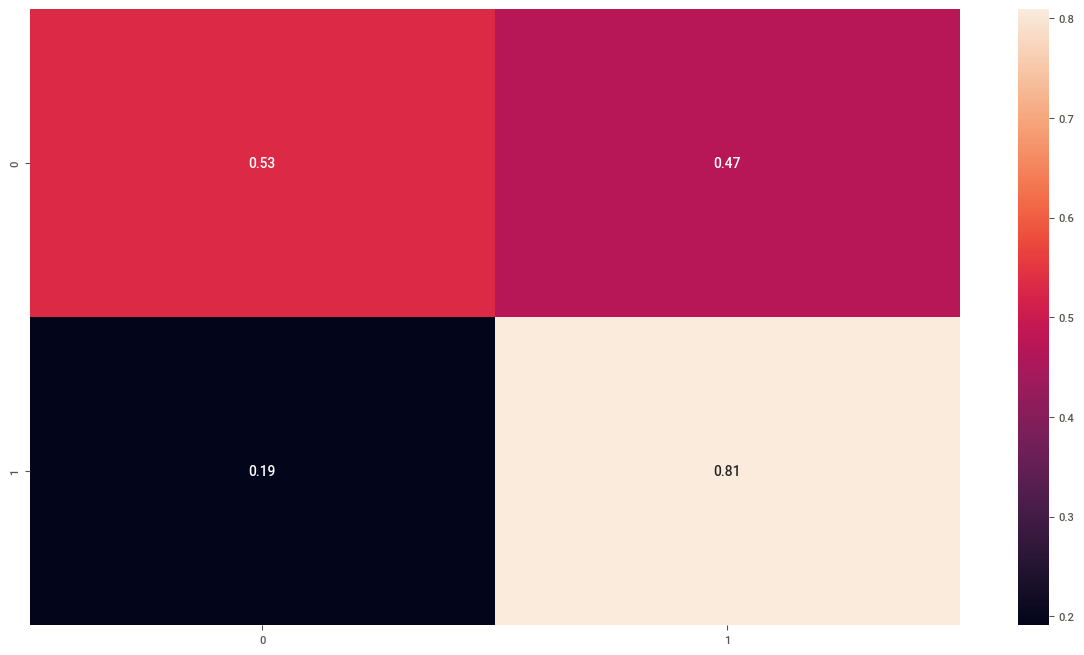

In [146]:
# Test values confusion matrix

test_value_predictions_proba_v1 = value_predictor_v1.predict_proba(test_players_prepared)

conf_mx = confusion_matrix(test_players_labels, test_value_predictions_proba_v1[:, 1] > ideal_threshold)
conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mx, annot=True, fmt='.2f')

In [147]:
# Try with test model

test_value_predictions_proba_v1 = value_predictor_v1.predict_proba(test_players_prepared)

test_players_v1 = x_test[['Name', 'Age', 'Position', 'Club', 'PA', 'value_diff']]
test_players_v1['pred'] = test_value_predictions_proba_v1[:, 1] > ideal_threshold

test_total_value_without_model = test_players_v1['value_diff'].sum()
test_total_value_with_model = test_players_v1.query('pred == 1')['value_diff'].sum()
test_max_value_without_model = test_players_v1.query('value_diff > 0')['value_diff'].sum()

test_performance = (test_total_value_with_model - test_total_value_without_model) / test_total_value_without_model
max_test_performance = (test_max_value_without_model - test_total_value_without_model) / test_total_value_without_model

print("Perf:", test_performance)
print("Max Perf:", max_test_performance)
print("Value diff from max:", test_max_value_without_model - test_total_value_with_model)

Perf: 2.4022275133857063
Max Perf: 4.091133891666384
Value diff from max: 506019999.0


In [149]:
import sweetviz as sv
report = sv.analyze(base_players_dataset)
report.show_html()

test_players_errors = x_test.copy()
test_players_errors['pred'] = test_value_predictions_proba_v1[:, 1] > ideal_threshold
test_players_errors['real'] = test_players_errors['value_diff'] > 0
test_players_false_pos = test_players_errors.query('pred == 1 & real == 0')
test_players_false_neg = test_players_errors.query('pred == 0 & real == 1')

# report = sv.analyze(test_players_false_pos)
# report.show_html()

report = sv.analyze(test_players_false_neg)
report.show_html()

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:04 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:04 -> (00:00 left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
